# The Box-Jenkins methodology for the SARIMA model

### Méthodologie de Box-Jenkins pour le Modèle SARIMA

### Step 1: Model Identification
* **Data Analysis**: Examiner les données de la série temporelle pour détecter les tendances, les saisonnalités et les comportements anormaux.
* **Differencing**: Si la série temporelle présente une tendance ou une saisonnalité, appliquer une différenciation pour rendre les données stationnaires.
* **Order Identification**: Utiliser les graphiques ACF (fonction d'autocorrélation) et PACF (fonction d'autocorrélation partielle) pour déterminer les ordres p, d, q, P, D, et Q du modèle SARIMA#.

## Step 2: Model Estimation
* **Parameter Estimation**: Utiliser les méthodes d'estimation (telles que la méthode des moindres carrés) pour estimer les paramètres du modèle SARIMA.

## Step 3: Model Verification
* **Model Diagnostics**: Vérifier si les résidus du modèle SARIMA sont bruit blanc (c'est-à-dire s'ils ne présentent pas de structure ou de corrélation significative).
* **Model Adjustment**: Si le modèle ne satisfait pas les critères de bruit blanc, ajuster les ordres du modèle SARIMA et répéter les étapes précédentes.
* **Validation**: Valider les performances du modèle en effectuant des prédictions sur des données de validation ou en utilisant des mesures d'évaluation telles que l'erreur quadratique moyenne (RMSE) ou le critère d'information d'Akaike (AIC).

## Note
La méthodologie de Box-Jenkins est itérative, ce qui signifie que les étapes d'identification, d'estimation et de vérification peuvent être répétées plusieurs fois pour améliorer le modèle. L'objectif est de trouver le meilleur modèle SARIMA qui capture les motifs et les caractéristiques importantes de la série temporelle, et qui peut être utilisé pour effectuer des prédictions précises.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Install library
#!pip install meteostat

In [6]:
# Import Meteostat library and dependencies
from meteostat import Point, Monthly

# Set time period
start = datetime.datetime(1970, 3, 1)
end = datetime.datetime(2022, 12, 31)

# Create Point for Madrid
location = Point(40.416775, -3.703790, 657)

# Get daily data for March 2023
df_madrid = Monthly(location, start, end)
df_madrid = df_madrid.fetch()

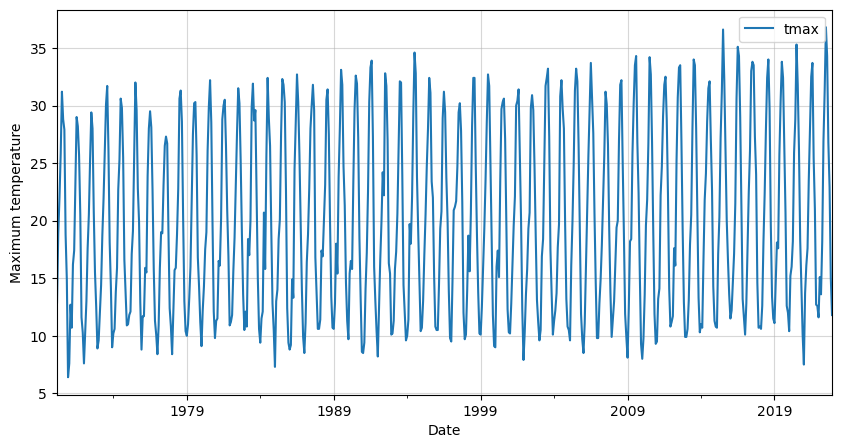

In [7]:
df_temp_max = df_madrid[['tmax']]

# Visualize the data
df_temp_max.plot(figsize=(10,5))
plt.grid(alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.show()

In [8]:
df_temp_max.isna().sum()

tmax    0
dtype: int64

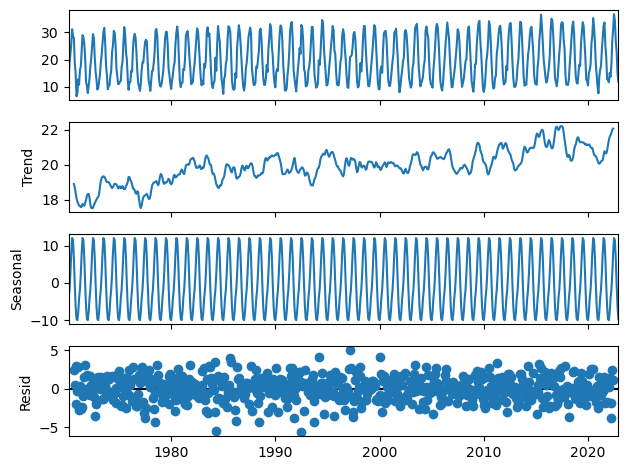

In [9]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df_temp_max,
                                          model='additive',
                                          period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposition.plot()
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

# Effectuer le test de Dickey-Fuller augmenté
result = adfuller(df_temp_max)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))

| Métrique       | Valeur                    |
|----------------|---------------------------|
| Valeur de test | -2.9718725902432044       |
| P-valeur       | 0.03760595188739065       |
| Conclusion     | La série est stationnaire |


In [11]:
from statsmodels.tsa.stattools import kpss
from tabulate import tabulate

# Effectuer le test KPSS
result = kpss(df_temp_max)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La série est non stationnaire']
]

# Afficher les résultats sous forme de tableau
print(tabulate(table, headers=['Métrique', 'Valeur'], tablefmt='github'))


| Métrique       | Valeur                        |
|----------------|-------------------------------|
| Valeur de test | 0.23003042556646808           |
| P-valeur       | 0.1                           |
| Conclusion     | La série est non stationnaire |


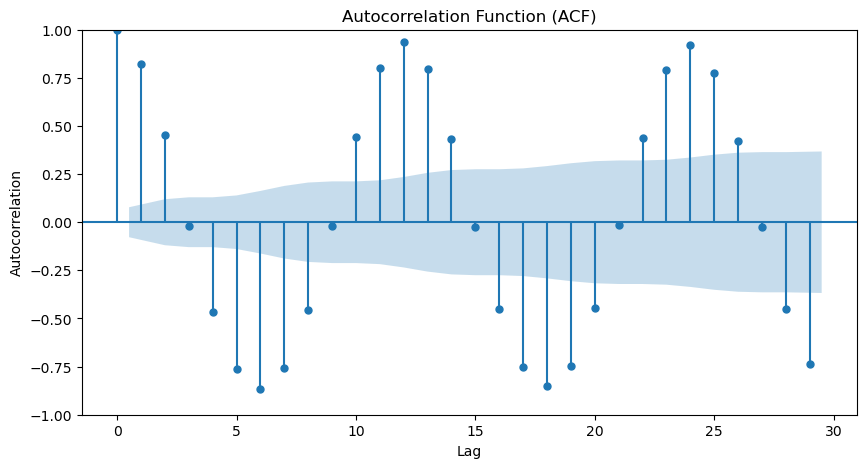

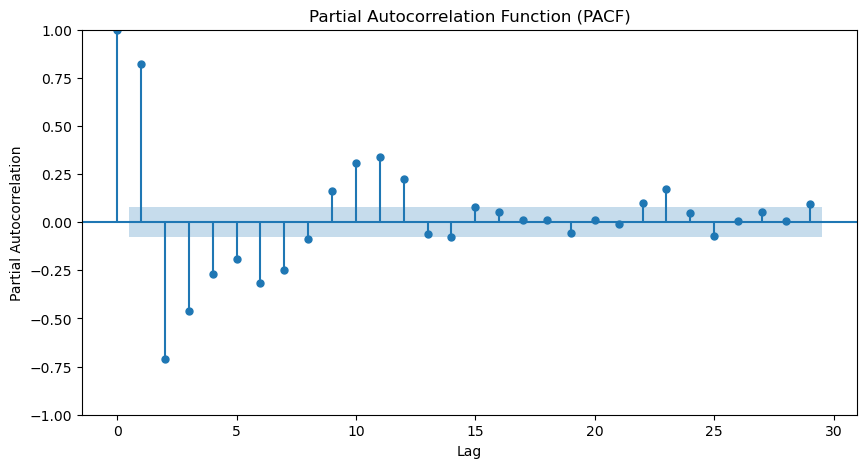

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(df_temp_max, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(df_temp_max, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

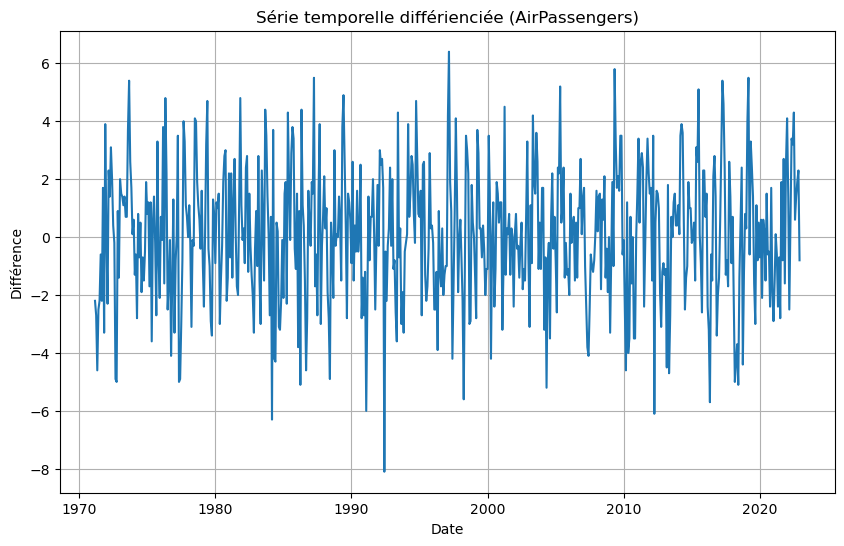

In [13]:
differenced12 = df_temp_max.diff(12).dropna()

# Afficher la série différienciée
plt.figure(figsize=(10, 6))
plt.plot(differenced12)
plt.title('Série temporelle différienciée (AirPassengers)')
plt.xlabel('Date')
plt.ylabel('Différence')
plt.grid(True)
plt.show()

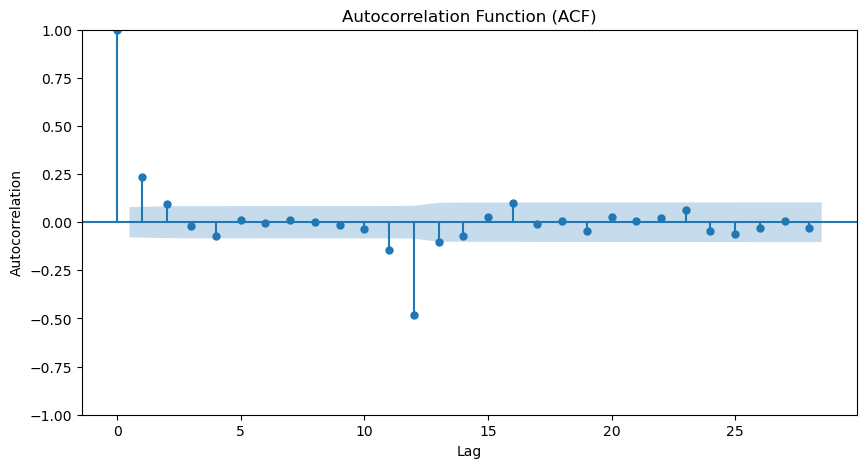

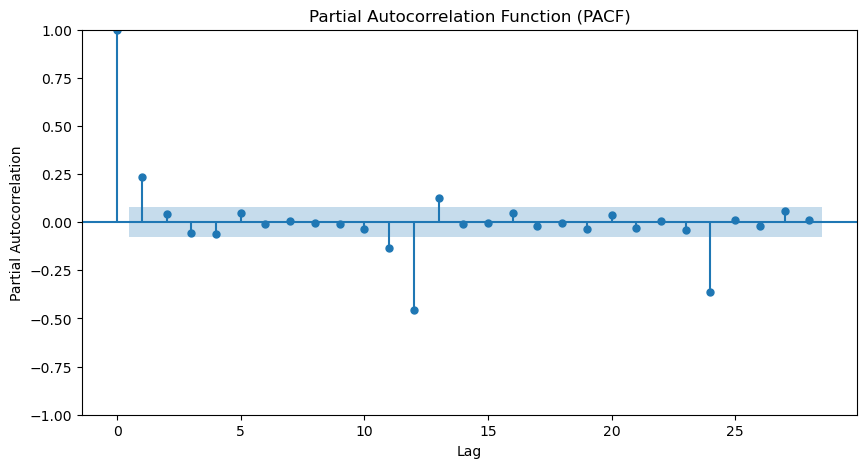

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(10, 5))
plot_acf(differenced12, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
plot_pacf(differenced12, ax=ax)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

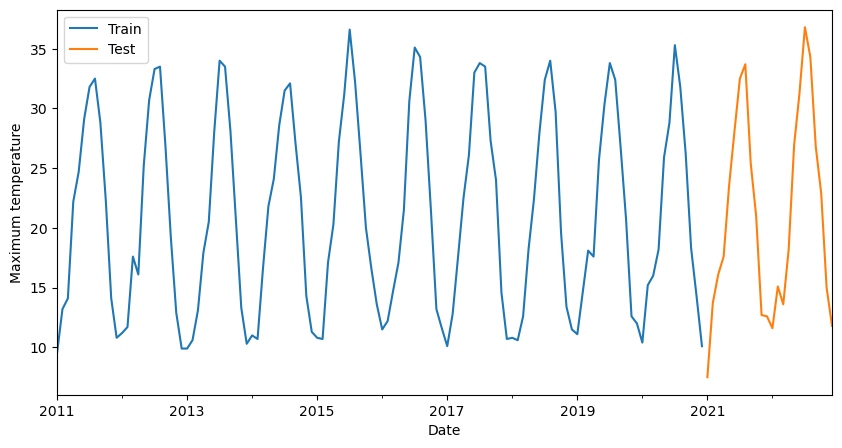

In [15]:
# Split into training and testing
df_train = df_temp_max.loc[:'2020']
df_test = df_temp_max.loc['2021':]

# Plot the last 10 years of training data and the 2 of testing
ax = df_train[-12*10:].plot(figsize=(10, 5))
df_test.plot(ax=ax)
plt.legend(['Train', 'Test'])
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.show()

In [16]:
my_order = (0,0,2)
my_seasonal_order = (2, 1, 3, 12)
# define model
model = SARIMAX(df_train, order=my_order, seasonal_order=my_seasonal_order)

In [17]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 11.127485275268555


In [18]:
#summary of the model
print(model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                       tmax   No. Observations:                  610
Model:             SARIMAX(0, 0, 2)x(2, 1, [1, 2, 3], 12)   Log Likelihood               -1167.279
Date:                                    Wed, 25 Sep 2024   AIC                           2350.557
Time:                                            12:06:36   BIC                           2385.706
Sample:                                        03-01-1970   HQIC                          2364.242
                                             - 12-01-2020                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2185      0.039      5.559      0

Let's observe the summary. We will focus on the coefficients section. Below are the parameter estimates of our SARIMA model:

* The autoregressive terms (ar.L1 and ar.L2) have estimated coefficients of 1.2218 and -0.2248, respectively.
* The moving average term (ma.L1) has an estimated coefficient of -0.9846. The seasonal autoregressive term (ar.S.L12) has an estimated coefficient of 0.9988.
* The seasonal moving average term (ma.S.L12) has an estimated coefficient of -0.8444.
* The estimated variance of the error term (sigma2) is 2.9183. The "P>|z|" column provides the p-value associated with each coefficient; in all cases, they are less than 0.05, our significance level, which means that all are statistically significant.

After fitting an ARIMA model, it is crucial to check the model's residuals to ensure the quality of the fit. Residuals are the difference between the observed values and the values predicted by the model. If the model is well-fitted, the residuals should behave like white noise, i.e., a random time series with a normal distribution, a mean of zero, and no autocorrelation. Here are some key points to check:

**Ljung-Box Test**
* The Ljung-Box test checks for the absence of autocorrelation in the residuals. We want the residuals to be independent of each other. A low p-value (p < 0.05) indicates evidence of autocorrelation.

**Heteroscedasticity**
* Heteroscedasticity refers to the situation where the variability of the prediction error (or residual) is not constant across all observations. We prefer to have a constant prediction error, so checking for heteroscedasticity is important. A good model should exhibit homoscedasticity, i.e., constant variance of the residuals.

**Normality**
* Normality refers to the distribution of the residuals. In a good model, we expect the residuals to follow a normal distribution. To check this, we can use a Q-Q plot or perform a statistical test, such as the Shapiro-Wilk test, to verify normality.

**Residual Plots**
* In addition to statistical tests, it is useful to plot the residuals over time, as well as their autocorrelation (ACF and PACF), to visually check the previous assumptions. In a well-fitted model, the residuals should resemble white noise when plotted over time, and the ACF and PACF should show little or no significant correlation.

Remember, no model is perfect, and all these tests and plots are tools to help you understand if your model is "good enough" to meet your specific needs.

<Figure size 1000x500 with 0 Axes>

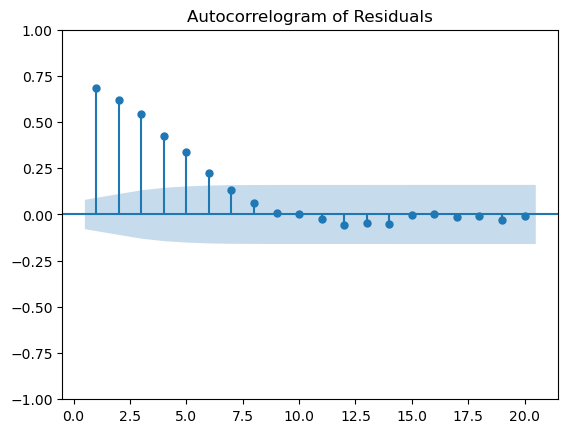

<Figure size 1000x500 with 0 Axes>

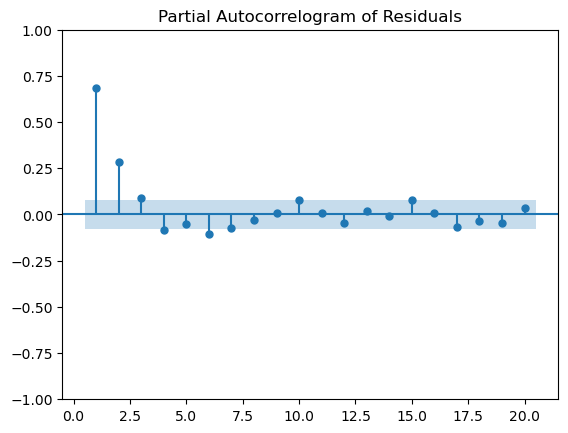

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer les résidus
residuals = model_fit.resid

# Tracer l'ACF des résidus
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=20, zero=False)
plt.title("Autocorrelogram of Residuals")
plt.show()

# Tracer la PACF des résidus
plt.figure(figsize=(10, 5))
plot_pacf(residuals, lags=20, zero=False)
plt.title("Partial Autocorrelogram of Residuals")
plt.show()

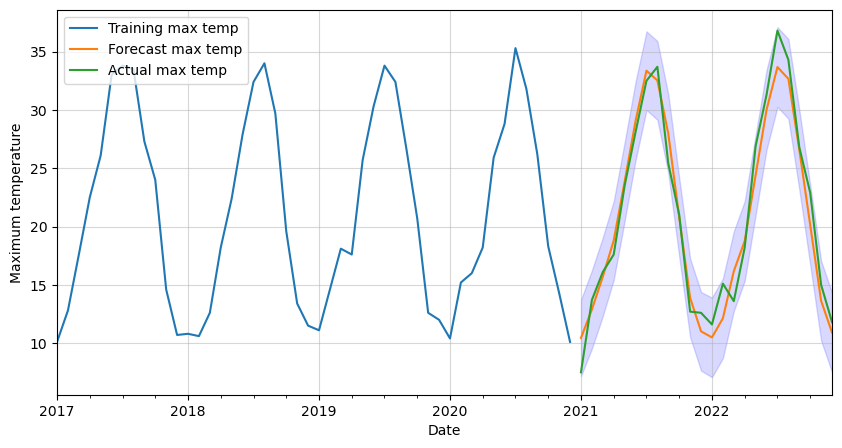

In [20]:
# Get forecast and confidence intervals for two years
forecast = model_fit.get_forecast(steps=24)
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot forecast with training data
ax = df_train[-12*4:].plot(figsize=(10,5))
forecast_values.plot()
df_test.plot(ax=ax)
plt.fill_between(forecast_values.index,
                 confidence_intervals['lower tmax'],
                 confidence_intervals['upper tmax'],
                 color='blue',
                 alpha=0.15)
plt.legend(['Training max temp',
            'Forecast max temp',
            'Actual max temp'],
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Maximum temperature')
plt.grid(alpha=0.5)
plt.show()

In [21]:
# Predicted values and actual values
predicted_values = forecast_values.values
actual_values = df_test.values.flatten()

# Mean Absolute Error (MAE)
mae = np.mean(np.abs(predicted_values - actual_values))
print("MAE:", mae)

# Root Mean Squared Error (RMSE)
mse = np.mean((predicted_values - actual_values) ** 2)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((predicted_values - actual_values) / actual_values)) * 100
print("MAPE:", mape)

MAE: 1.4667555786171274
RMSE: 1.7344392772231958
MAPE: 8.575902205861281
